In [1]:
import numpy as np 
import matplotlib.pyplot as plt## 
# from keras.datasets import mnist
# Used for Confusion Matrix
from sklearn import metrics
# Used for Loading MNIST
from struct import unpack
# Used for Predicting Model
from sklearn.linear_model import LogisticRegression
# Used for calculating result and accuracy
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
# Used for scaling image data
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [3]:
def load_data():
    train_img, train_lbl = loadmnist(
        'mnist/train-images.idx3-ubyte', 'mnist/train-labels.idx1-ubyte')
    test_img, test_lbl = loadmnist(
        'mnist/t10k-images.idx3-ubyte', 'mnist/t10k-labels.idx1-ubyte') 
    input_dim = 28*28 
    train_img = train_img.reshape(60000, input_dim) 
    test_img = test_img.reshape(10000, input_dim) 
    train_img = train_img.astype('float32') 
    test_img = test_img.astype('float32') 
    train_img /= 255 
    test_img /= 255
    return train_img, train_lbl, test_img, test_lbl

In [4]:
train_img, train_lbl, test_img, test_lbl = load_data()
scaler = preprocessing.StandardScaler().fit(train_img)
train_img = scaler.transform(train_img)
scaler = preprocessing.StandardScaler().fit(test_img)
test_img = scaler.transform(test_img)

In [ ]:
# train 600 and if labeled wasn't more than 600 then add 600 more

In [5]:
    X_train, y_train, X_test, y_test = train_img, train_lbl, test_img, test_lbl
    train_f1s = []
    test_f1s = []
    pseudo_labels = []
    high_prob_counter = 1
    total_pseudo_labelled = 0
    total_prelabelled_added = 0
    X_train_s = np.empty((0,784))
    y_train_s = np.empty(0)
    X_plabelled = np.empty((0,784))
    y_plabelled = np.empty(0)
    unlabelled_missed = np.empty((0,784))
    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
    i = 0
    epoch = 0
    while high_prob_counter > 0:
        high_prob_counter = 0

        if X_plabelled.shape[0] > 600:
              X_train_s = np.append(X_train_s, X_plabelled[:600], axis=0)
              y_train_s = np.append(y_train_s, y_plabelled[:600])

              X_plabelled = X_plabelled[600:]
              y_plabelled = y_plabelled[600:]

        elif i < 100:
              X_train_s = np.append(X_train_s, X_train[(600*i):(600*(i+1))], axis=0)
              y_train_s = np.append(y_train_s, y_train[(600*i):(600*(i+1))])

              total_prelabelled_added += 600
              i += 1
        else:
              X_train_s = np.append(X_train_s, X_plabelled, axis=0)
              y_train_s = np.append(y_train_s, y_plabelled)

              X_plabelled = np.empty((0,784))
              y_plabelled = np.empty(0)
              

        print(f"Iteration: {epoch}")
        print(f"{X_train_s.shape[0]} new labelled data is training.")

        #logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
        logisticRegr.fit(X_train_s, y_train_s)

        y_test_pred = logisticRegr.predict(X_test)
        y_train_pred = logisticRegr.predict(X_train)

        train_f1 = f1_score(y_train, y_train_pred, average=None)
        test_f1 = f1_score(y_test, y_test_pred, average=None)

        print(f"Train f1 Score: {train_f1}")
        print(f"Test f1 Score: {test_f1}")

        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        
        if i < 100:
            unlabelled_splitted = X_train[(600*(i)):(600*(i+1))]
            i += 1
        elif unlabelled_missed.shape[0] > 600:
            unlabelled_splitted = unlabelled_missed[:600]
            unlabelled_missed = unlabelled_missed[600:]
        else:
            unlabelled_splitted = unlabelled_missed
            unlabelled_missed = np.empty((0,784))
        

        if unlabelled_splitted.shape[0] > 600:
            unlabeled_pred_prob = logisticRegr.predict_proba(unlabelled_splitted[:600])
            unlabelled_missed = np.append(unlabelled_missed, unlabelled_splitted[600:], axis=0)
        else:
            unlabeled_pred_prob = logisticRegr.predict_proba(unlabelled_splitted)
        
        #print(unlabelled_splitted.shape, unlabelled_missed.shape)

        print(f"Now predicting labels for unlabeled data...")

        high_prob_idx = []

        for j in range(unlabeled_pred_prob.shape[0]):
            max = 0
            pseudo_label = 0
            #print(unlabelled_splitted[j].shape)
            pred_prob = unlabeled_pred_prob[j]
            #print(pred_prob.shape)
            #print(i, " ", pred_prob)
            for k in range(pred_prob.shape[0]):
                if pred_prob[k] > max:
                    max = pred_prob[k]
                    pseudo_label = k
            if max >= 0.95:
                high_prob_counter += 1
                high_prob_idx.append(j)
                #print(unlabelled_splitted.shape)
                #print(X_plabelled.shape)
                X_plabelled = np.append(X_plabelled, [unlabelled_splitted[j]], axis=0)
                y_plabelled = np.append(y_plabelled, pseudo_label)
            else:
                unlabelled_missed = np.append(unlabelled_missed, [unlabelled_splitted[j]], axis=0)

        print(f"{high_prob_counter} high-probability unlabelled predictions is labelled and added to next train dataset.")

        print(f"{unlabelled_missed.shape[0]} unlabelled instances remained to be predict in next iteration")

        print(f"{X_plabelled.shape[0]} labelled instances are going to be added to train dataset in next iteration.")

        
        total_pseudo_labelled += high_prob_counter
        pseudo_labels.append(high_prob_counter)
        epoch += 1
    
    print("*** Model's Learning is finished. ***")
    print(f"In the end, {total_prelabelled_added} pre-labelled images and {total_pseudo_labelled} pseudo-labelled images added to train dataset")

Iteration: 0
600 new labelled data is training.
Train f1 Score: [0.90200943 0.91926972 0.8215555  0.8169829  0.8331299  0.76465776
 0.880468   0.85729831 0.78784141 0.75220718]
Test f1 Score: [0.9058296  0.93367347 0.83536883 0.82562278 0.83758938 0.75135722
 0.8688172  0.8502598  0.79639449 0.76782077]
Now predicting labels for unlabeled data...
368 high-probability unlabelled predictions is labelled and added to next train dataset.
232 unlabelled instances remained to be predict in next iteration
368 labelled instances are going to be added to train dataset in next iteration.
Iteration: 1
1200 new labelled data is training.
Train f1 Score: [0.92495637 0.93172231 0.84596617 0.80923472 0.85263158 0.78757239
 0.90495269 0.8751417  0.79251857 0.80327338]
Test f1 Score: [0.92354125 0.94444444 0.85372849 0.81776417 0.87263682 0.78100559
 0.89017951 0.86956522 0.80087527 0.82163743]
Now predicting labels for unlabeled data...
456 high-probability unlabelled predictions is labelled and added

<class 'numpy.ndarray'>


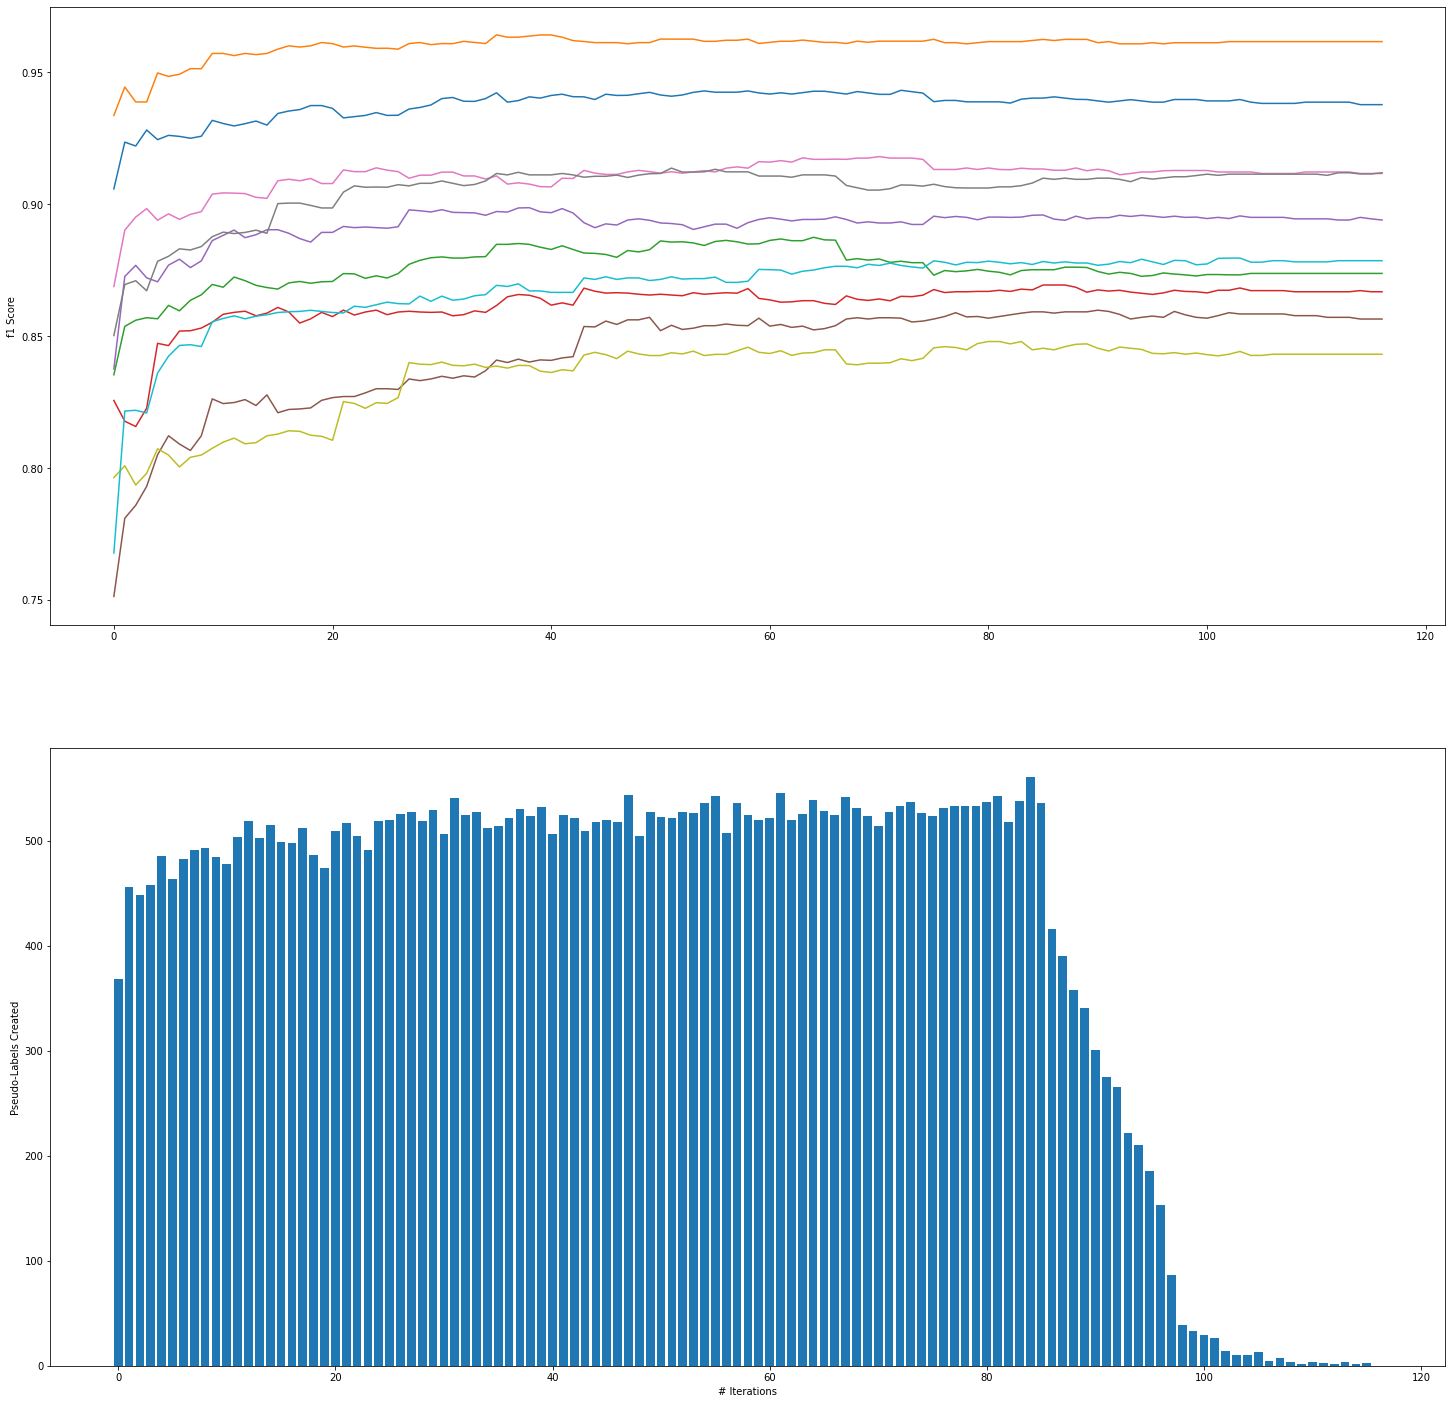

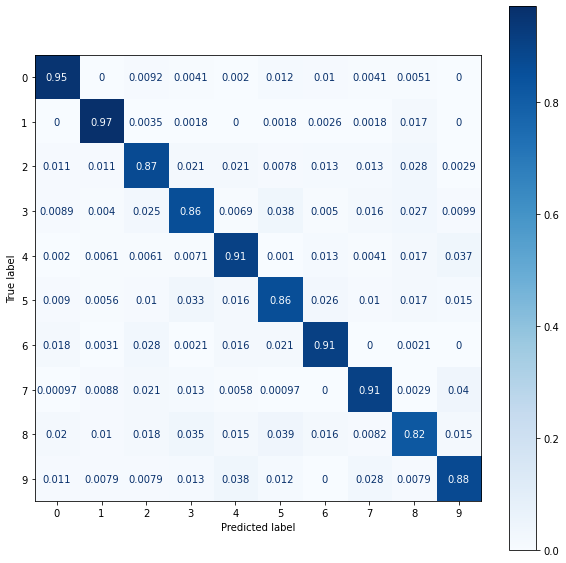

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,25))
ax1.plot(range(epoch), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(epoch), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training
fig, ax = plt.subplots(figsize=(10, 10))
print(type(y_test))
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ax=ax)

In [ ]:
# 600 pre-train and rest will predict

In [ ]:
    X_train, y_train, X_test, y_test = train_img, train_lbl, test_img, test_lbl
    train_f1s = []
    test_f1s = []
    pseudo_labels = []
    high_prob_counter = 1
    total_pseudo_labelled = 0
    total_prelabelled_added = 0
    X_train_s = np.empty((0,784))
    y_train_s = np.empty(0)
    X_plabelled = np.empty((0,784))
    y_plabelled = np.empty(0)
    unlabelled_missed = np.empty((0,784))
    logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
    i = 0
    X_train_s = np.append(X_train_s, X_train[(600*i):(600*(i+1))], axis=0)
    y_train_s = np.append(y_train_s, y_train[(600*i):(600*(i+1))])
    total_prelabelled_added += 600
    i += 1
    epoch = 0
    while high_prob_counter > 0:
        high_prob_counter = 0

        if X_plabelled.shape[0] > 600:
              X_train_s = np.append(X_train_s, X_plabelled[:600], axis=0)
              y_train_s = np.append(y_train_s, y_plabelled[:600])

              X_plabelled = X_plabelled[600:]
              y_plabelled = y_plabelled[600:]
              
        print(f"Iteration: {epoch}")
        print(f"{X_train_s.shape[0]} new labelled data is training.")

        #logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
        logisticRegr.fit(X_train_s, y_train_s)

        y_test_pred = logisticRegr.predict(X_test)
        y_train_pred = logisticRegr.predict(X_train)

        train_f1 = f1_score(y_train, y_train_pred, average=None)
        test_f1 = f1_score(y_test, y_test_pred, average=None)

        print(f"Train f1 Score: {train_f1}")
        print(f"Test f1 Score: {test_f1}")

        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

        
        if i < 100:
            unlabelled_splitted = X_train[(600*(i)):(600*(i+1))]
            i += 1
        elif unlabelled_missed.shape[0] > 600:
            unlabelled_splitted = unlabelled_missed[:600]
            unlabelled_missed = unlabelled_missed[600:]
        else:
            unlabelled_splitted = unlabelled_missed
            unlabelled_missed = np.empty((0,784))
        

        if unlabelled_splitted.shape[0] > 600:
            unlabeled_pred_prob = logisticRegr.predict_proba(unlabelled_splitted[:600])
            unlabelled_missed = np.append(unlabelled_missed, unlabelled_splitted[600:], axis=0)
        else:
            unlabeled_pred_prob = logisticRegr.predict_proba(unlabelled_splitted)
        
        #print(unlabelled_splitted.shape, unlabelled_missed.shape)

        print(f"Now predicting labels for unlabeled data...")

        high_prob_idx = []

        for j in range(unlabeled_pred_prob.shape[0]):
            max = 0
            pseudo_label = 0
            #print(unlabelled_splitted[j].shape)
            pred_prob = unlabeled_pred_prob[j]
            #print(pred_prob.shape)
            #print(i, " ", pred_prob)
            for k in range(pred_prob.shape[0]):
                if pred_prob[k] > max:
                    max = pred_prob[k]
                    pseudo_label = k
            if max >= 0.95:
                high_prob_counter += 1
                high_prob_idx.append(j)
                #print(unlabelled_splitted.shape)
                #print(X_plabelled.shape)
                X_plabelled = np.append(X_plabelled, [unlabelled_splitted[j]], axis=0)
                y_plabelled = np.append(y_plabelled, pseudo_label)
            else:
                unlabelled_missed = np.append(unlabelled_missed, [unlabelled_splitted[j]], axis=0)

        print(f"{high_prob_counter} high-probability unlabelled predictions is labelled and added to next train dataset.")

        print(f"{unlabelled_missed.shape[0]} unlabelled instances remained to be predict in next iteration")

        print(f"{X_plabelled.shape[0]} labelled instances are going to be added to train dataset in next iteration.")

        
        total_pseudo_labelled += high_prob_counter
        pseudo_labels.append(high_prob_counter)
        epoch += 1
    
    print("*** Model's Learning is finished. ***")
    print(f"In the end, {total_prelabelled_added} pre-labelled images and {total_pseudo_labelled} pseudo-labelled images added to train dataset")

Iteration: 0
600 new labelled data is training.
Train f1 Score: [0.90200943 0.91926972 0.8215555  0.8169829  0.8331299  0.76465776
 0.880468   0.85729831 0.78784141 0.75220718]
Test f1 Score: [0.9058296  0.93367347 0.83536883 0.82562278 0.83758938 0.75135722
 0.8688172  0.8502598  0.79639449 0.76782077]
Now predicting labels for unlabeled data...
368 high-probability unlabelled predictions is labelled and added to next train dataset.
232 unlabelled instances remained to be predict in next iteration
368 labelled instances are going to be added to train dataset in next iteration.
Iteration: 1
600 new labelled data is training.
Train f1 Score: [0.90200943 0.91926972 0.8215555  0.8169829  0.8331299  0.76465776
 0.880468   0.85729831 0.78784141 0.75220718]
Test f1 Score: [0.9058296  0.93367347 0.83536883 0.82562278 0.83758938 0.75135722
 0.8688172  0.8502598  0.79639449 0.76782077]
Now predicting labels for unlabeled data...
382 high-probability unlabelled predictions is labelled and added 

<class 'numpy.ndarray'>


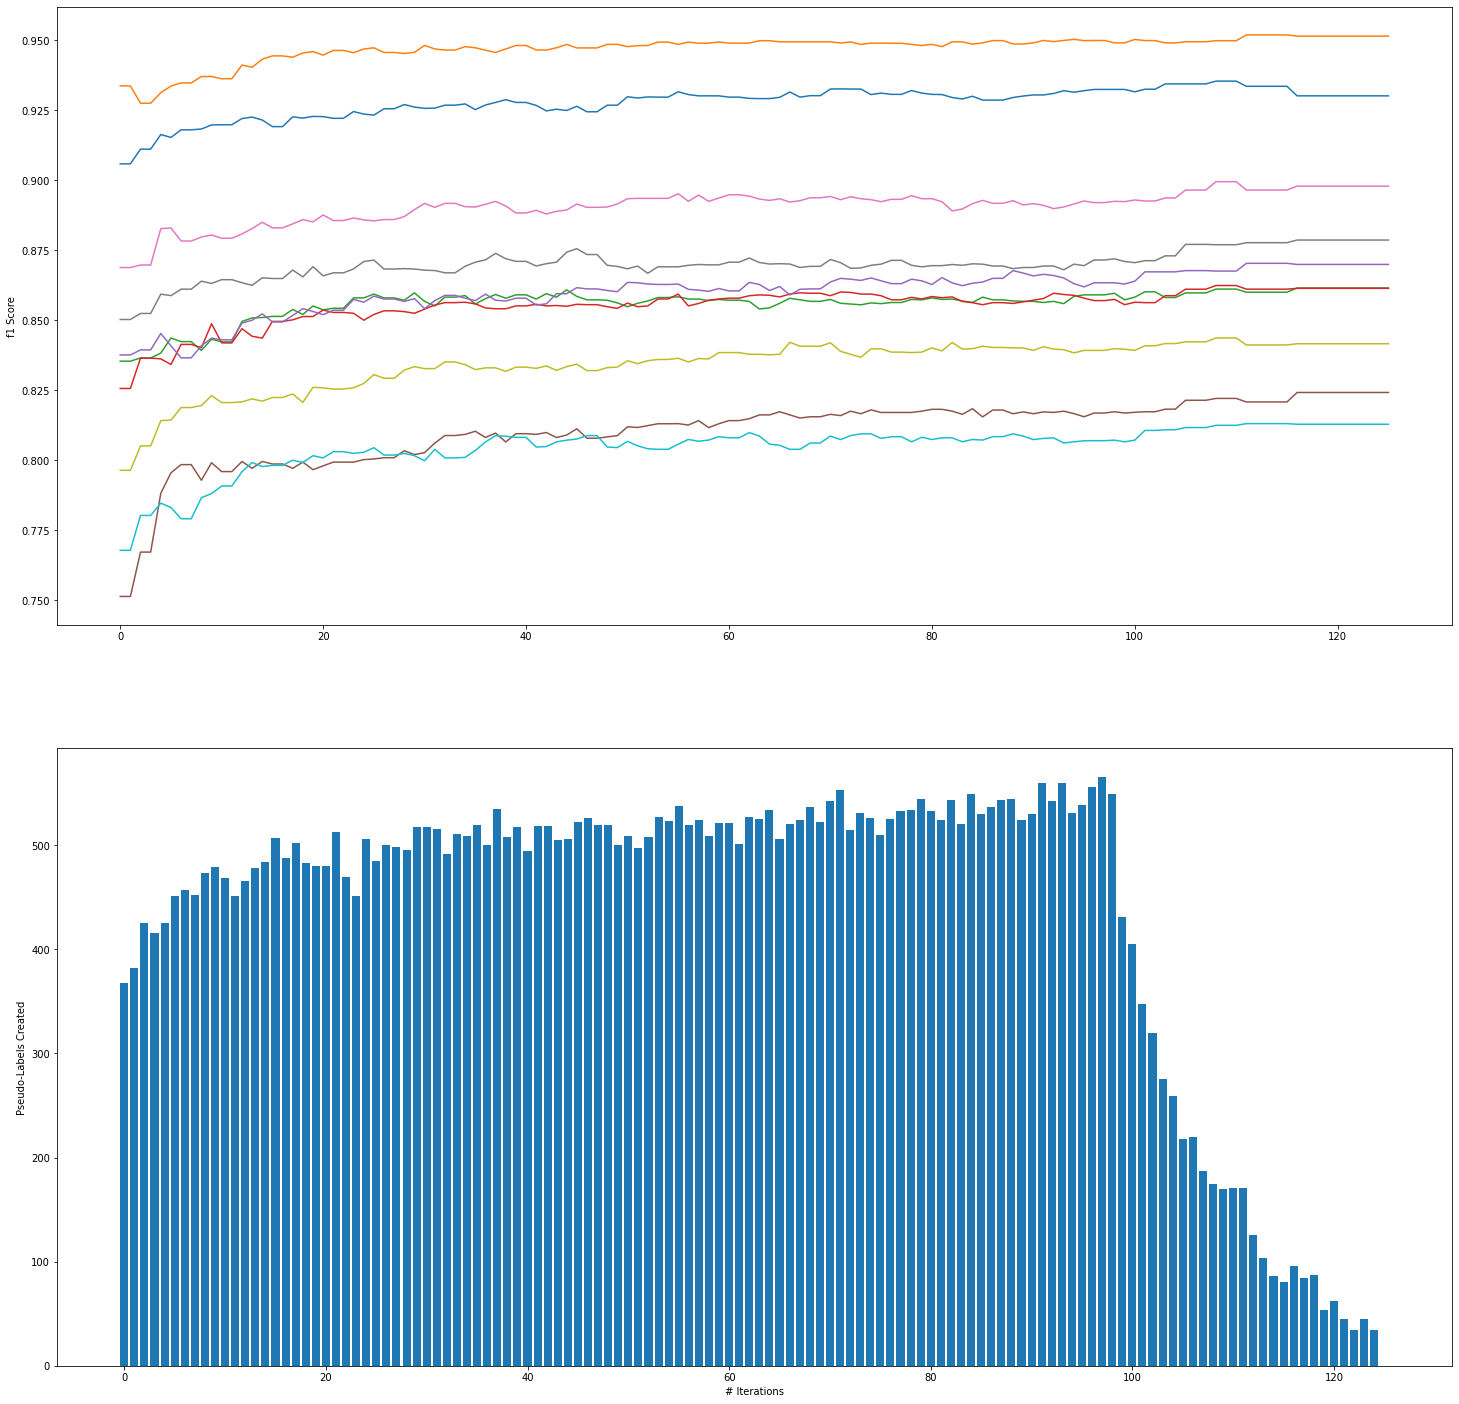

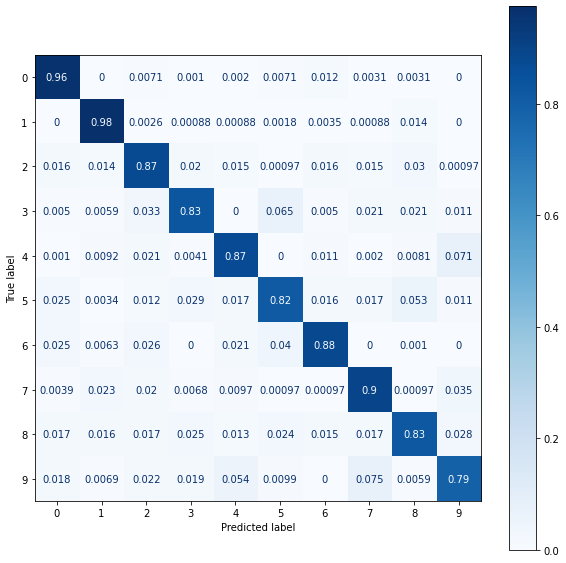

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,25))
ax1.plot(range(epoch), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(epoch), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training
fig, ax = plt.subplots(figsize=(10, 10))
print(type(y_test))
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ax=ax)